# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

# 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Remember the SVM primal optimization problem in the linearly separable case is defined as
$$
\begin{align}
\min_{\mathbf{w},b}\quad &\frac{\|\mathbf{w}\|}{2}, \\
s.t.\quad&y^{(i)} (\mathbf{w^T}\mathbf{x}^{(i)}+b) \ge 1 &\forall i \in \{1,\dots,N\}
\end{align}
$$
Explain in words why in this case it is **not equivalent** to solve the original problem with a separate bias term $b$, and a reformulation of the problem using a padding of 1 to each sample (effectively ignoring the bias term in the original formulation, and letting the coordinate of $w$ which corresponds to the padding serve as the bias).

2. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

3. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

4. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

5. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

6. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

**Q1**: why in this case it is not equivalent to solve the original problem with a separate bias term  b , and a reformulation of the problem using a padding of 1 to each sample?

**A1**: The bias shifts the classification scores up or down by the same amount for all data points. In particular, the bias does not change the shape of the classifier or its margin size. Therefore, the bias term in SVM should NOT be regularized. If you change the θ to include the intercept term b, the norm of the θ will be affected by the size of the intercept, which will cause the SVM to optimize towards a small intercept, which affext the entire regularzation expression

In [1]:
import numpy as np
import random
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score,make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score,validation_curve,KFold, learning_curve
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

**2.** Implement a class PegasosSVM which has parameter  λ  and  T  and methods fit and predict and decision_function

In [2]:
class PegasosSVM():

    def __init__(self, lambda1=1, iterations=1000):
        self.lambda1 = lambda1
        self.iter = iterations

    def fit(self,X,y):
        # Pad the X
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        # initialize the weights
        self.w = np.zeros(X.shape[1]).reshape(1,-1)
        y_sign = np.sign(y)
        for t in range(self.iter):
            i = random.randint(0,X.shape[1])
            y_i = y_sign[i]
            X_i = X[i,:]
            #? Not sure if this is how to implement step_size ?#
            step_n = 1 / (self.lambda1*(t+1))
            score = y_i* self.w.dot(X_i.T).T

            if score < 1:
                self.w = (1-step_n*self.lambda1)*self.w + step_n*y_i*X_i
            else:
                self.w = (1-step_n*self.lambda1)*self.w

            self.w = min(1.0/(np.sqrt(self.lambda1)*np.linalg.norm(self.w)),1)*self.w

        return self

    def predict(self,X):
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        return np.sign(X @ self.w.T)

    def decision_function(self,X,y):
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        dot = np.dot(X,self.w.T)
        return np.mean((dot*y<1).astype(int)*(y-dot))

**3.** Test your class on the breast cancer and compare your results to the Native Scikit-learn implementation

In [3]:
X,y = load_breast_cancer(return_X_y= True)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = PegasosSVM().fit(X_train,y_train)
print(clf.decision_function(X_test,y_test))

21.166063421994526


In [8]:
X,y = load_breast_cancer(return_X_y= True)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dec = 3
pegasos_pipe=make_pipeline(StandardScaler(),PegasosSVM())
pegasos_pipe.fit(X_train,y_train)

pegasos_scores=cross_val_score(pegasos_pipe, X_train, y_train,cv=5, scoring='accuracy');
pegasos_test_scores=accuracy_score(y_test,pegasos_pipe.predict(X_test))
print(f"PegasosSVM Training Set Score: {round(pegasos_scores.mean(), dec)}")
print(f"PegasosSVM Test Set Score: {round(peg_test_scores, dec)}")

model_pipeline = make_pipeline(StandardScaler(),LinearSVC())
model_pipeline.fit(X_train,y_train)
score=cross_val_score(model_pipeline,X_train,y_train,cv=5,scoring='accuracy');
test_scores=accuracy_score(y_test,model_pipeline.predict(X_test))
print(f"LinearSVC Training Set Score: {round(score.mean(), dec)}")
print(f"LinearSVC Test Set Score: {round(test_scores, dec)}")

PegasosSVM Training Set Score: 0.938
PegasosSVM Test Set Score: 0.956
LinearSVC Training Set Score: 0.971
LinearSVC Test Set Score: 0.956


**4.** Analyze the effect of the hyper parameter  λ  on your training and test error.

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

mean training score for lambda=0.01: 0.862,	 mean validation score:0.873
mean training score for lambda=0.26: 0.899,	 mean validation score:0.897
mean training score for lambda=0.51: 0.899,	 mean validation score:0.912
mean training score for lambda=0.76: 0.863,	 mean validation score:0.864
mean training score for lambda=1.0: 0.841,	 mean validation score:0.844
mean training score for lambda=1.3: 0.921,	 mean validation score:0.923
mean training score for lambda=1.5: 0.788,	 mean validation score:0.809
mean training score for lambda=1.8: 0.866,	 mean validation score:0.859
mean training score for lambda=2.0: 0.818,	 mean validation score:0.82
mean training score for lambda=2.3: 0.849,	 mean validation score:0.868
mean training score for lambda=2.5: 0.898,	 mean validation score:0.881
mean training score for lambda=2.8: 0.921,	 mean validation score:0.905
mean training score for lambda=3.0: 0.919,	 mean validation score:0.919
mean training score for lambda=3.3: 0.913,	 mean validation s

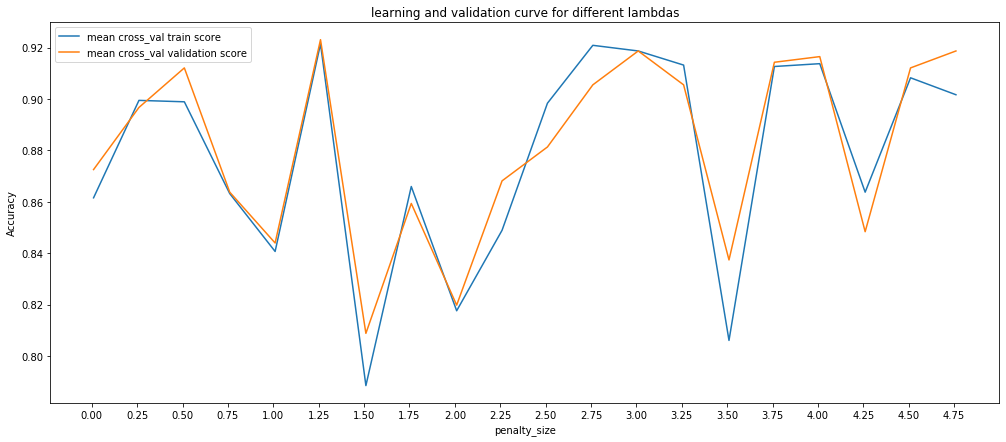

In [10]:
lam_score = make_scorer(accuracy_score)

train_scores, valid_scores = validation_curve(LinearSVC(max_iter=2000),X_train,y_train,'C',np.arange(0.01,5.01,0.25),cv=5,scoring=lam_score,verbose=0);

plt.figure(figsize=(17,7))
plt.title("learning and validation curve for different lambdas")
plt.xlabel("penalty_size")
plt.xticks(np.arange(0,5.01,0.25))
plt.ylabel('Accuracy')
plt.plot(np.arange(0.01,5.01,0.25),np.mean(train_scores,axis=1))
plt.plot(np.arange(0.01,5.01,0.25),np.mean(valid_scores,axis=1))
plt.legend(['mean cross_val train score','mean cross_val validation score'])

i=0
for t_lambda in np.arange(0.01,5.01,0.25):
    print ("mean training score for lambda={0:1.2}: {1:1.3},\t mean validation score:{2:1.3}".format(t_lambda,np.mean(train_scores[i]),np.mean(valid_scores[i])))
    i+=1



**5.** 
Analyze the learning curve 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: -1

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/sv

(10, 5)
mean training score for percentage size=0.01: nan,	 mean validation score:nan
mean training score for percentage size=0.11: 0.904,	 mean validation score:0.746
mean training score for percentage size=0.21: 0.863,	 mean validation score:0.849
mean training score for percentage size=0.31: 0.875,	 mean validation score:0.798
mean training score for percentage size=0.41: 0.854,	 mean validation score:0.81
mean training score for percentage size=0.51: 0.855,	 mean validation score:0.796
mean training score for percentage size=0.61: 0.875,	 mean validation score:0.84
mean training score for percentage size=0.71: 0.924,	 mean validation score:0.926
mean training score for percentage size=0.81: 0.841,	 mean validation score:0.796
mean training score for percentage size=0.91: 0.9,	 mean validation score:0.894


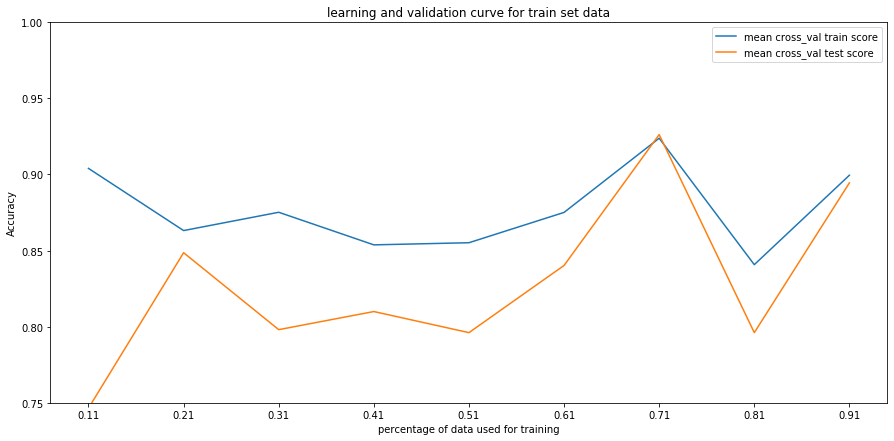

In [48]:
t_size, train_scores, test_scores = learning_curve(LinearSVC(),X,y,cv=5, train_sizes=np.arange(0.01,1.0,.1),scoring='accuracy')

train_sizes=np.arange(0.01,1.0,.1)

plt.figure(figsize=(15,7))
plt.title("learning and validation curve for train set data")
plt.xlabel("percentage of data used for training")
plt.xticks(np.arange(0.01,1.0,.1))
plt.ylabel('Accuracy')
plt.ylim(0.75,1)
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.legend(['mean cross_val train score','mean cross_val test score'])

print(train_scores.shape)

for i, lambd in enumerate(np.arange(0.01,1.0,.1)):
  print ("mean training score for percentage size={0:1.2f}: {1:1.3},\t mean validation score:{2:1.3}".format(lambd,np.mean(train_scores[i,:]),np.mean(test_scores[i,:])))


# 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


In [11]:
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [12]:
def make_data(x1_mu,x1_std,x2_mu,x2_std,n_samples=1000):

    x1, x2, y = np.zeros(n_samples), np.zeros(n_samples), np.zeros(n_samples)
    perc_1 = int(n_samples*0.1)

    y[:perc_1]= 0
    y[perc_1:]= 1

    gauss_1 = norm.rvs(size=perc_1, loc=x1_mu , scale=x1_std)
    gauss_2 = norm.rvs(size=n_samples-perc_1, loc=x1_mu, scale=x2_std)

    x1 = np.concatenate((gauss_1,gauss_2),axis=0)

  
    x2[:perc_1] = norm.rvs(size=perc_1, loc=x2_mu[0], scale=x2_std)
    x2[perc_1:] = norm.rvs(size=n_samples-perc_1, loc=x2_mu[1], scale=x2_std)
      
    x=np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)),axis=1)

    return x,y

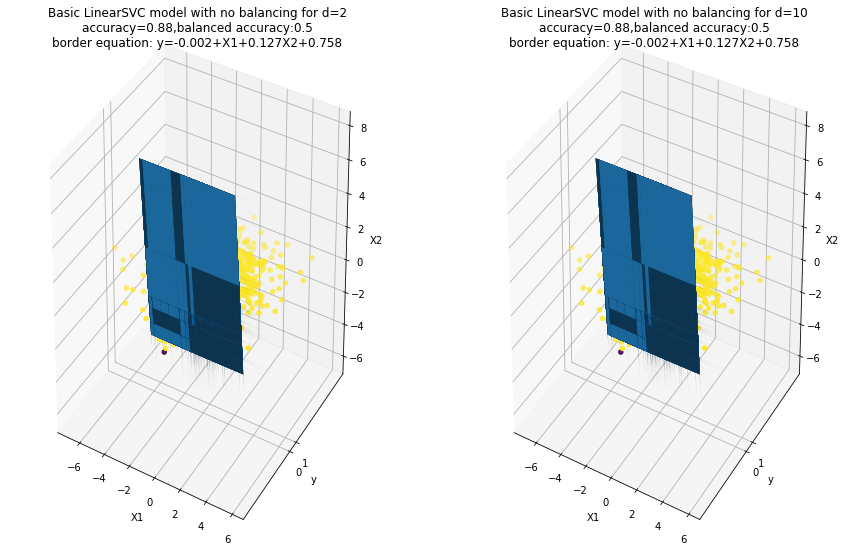

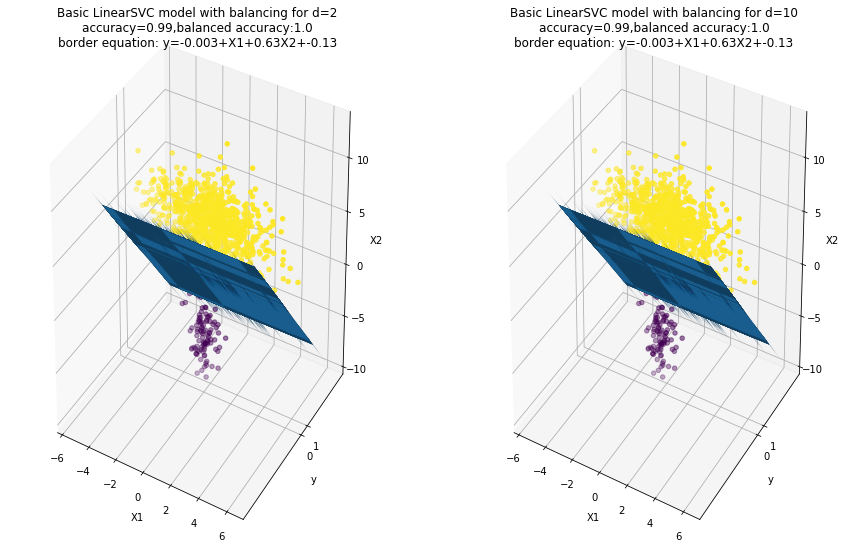

In [17]:
X_1,y_1=make_data(0,0.5,[-1,1],2)
X_2,y_2=make_data(0,0.5,[-5,5],2)


ds=[2,10]
svc=LinearSVC()

fig = plt.figure(figsize=(15,10))
i=1

for d in ds:
    X_train,X_test,y_train,y_test=train_test_split(X_1,y_1,test_size=0.3,random_state=42)
    svc.fit(X_train,y_train)
    a,b=svc.intercept_,svc.coef_
    z = lambda x: (-svc.intercept_[0]-b[0][0]*x[:,0]-b[0][1]*x[:,1])
    title = f"Basic LinearSVC model with no balancing for d={d}\n"
    title += f"accuracy={np.round(accuracy_score(y_test,svc.predict(X_test)),2)},"
    title += f"balanced accuracy:{np.round(balanced_accuracy_score(y_test,svc.predict(X_test)),2)}\n" 
    title += f"border equation: y={np.round(b[0][0],3)}+X1+{np.round(b[0][1],3)}X2+{np.round(a[0],3)}"
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('y')
    ax.set_yticks([0,1])
    ax.set_zlabel('X2')
    ax.plot_surface(X_1[:,0],z(X_1).reshape(-1,1),X_1[:,1].reshape(-1,1))
    ax.scatter(X_1[:,0], X_1[:,1], y_1, c=svc.predict(X_1))
    i+=1
    
fig = plt.figure(figsize=(15,10))
i=1
svc=LinearSVC(class_weight='balanced')
for d in ds:
    X_train,X_test,y_train,y_test=train_test_split(X_2,y_2,test_size=0.3,random_state=42)
    svc.fit(X_train,y_train)  
    a,b=svc.intercept_,svc.coef_
    z = lambda x: (-svc.intercept_[0]-b[0][0]*x[:,0]-b[0][1]*x[:,1])
    title = f"Basic LinearSVC model with balancing for d={d}\n"
    title += f"accuracy={np.round(accuracy_score(y_test,svc.predict(X_test)),2)},"
    title += f"balanced accuracy:{np.round(balanced_accuracy_score(y_test,svc.predict(X_test)),2)}\n" 
    title += f"border equation: y={np.round(b[0][0],3)}+X1+{np.round(b[0][1],3)}X2+{np.round(a[0],3)}"
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('y')
    ax.set_yticks([0,1])
    ax.set_zlabel('X2')
    ax.plot_surface(X_2[:,0],z(X_2).reshape(-1,1),X_2[:,1].reshape(-1,1))
    ax.scatter(X_2[:,0], y_2, X_2[:,1], c=svc.predict(X_2))
    i+=1

The problem with unbalanced labeles is that the base predicition of y according to the mode produces a relative high score in terms of accuracy, but with no real generelazation of a separating rule.

balancing the weights makes the model more robust because it put more emphasis on balancing the strict accuracy measurement in eachof the difeerently labeled groups.

#3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [25]:
from sklearn.model_selection import GridSearchCV

#X_2,y_2=make_data(0,1,0,0.5,[-5,5],2,0.1)
X_train,X_test,y_train,y_test=train_test_split(X_2,y_2,test_size=0.3,random_state=42)

svc=LinearSVC()
svc.fit(X_train,y_train);
base_acc=accuracy_score(svc.predict(X_test),y_test)
base_bacc=balanced_accuracy_score(svc.predict(X_test),y_test)

params={
'multi_class':['ovr', 'crammer_singer'],
'loss':['hinge', 'squared_hinge'],
'C':  np.logspace(-3,3,10)  
}
GSCV=GridSearchCV(LinearSVC(),params)
cv_scores = cross_val_score(GSCV, X_train, y_train)
GSCV.fit(X_train, y_train)
optimal_acc=accuracy_score(GSCV.predict(X_test),y_test)
optimal_bacc=balanced_accuracy_score(GSCV.predict(X_test),y_test)

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Adam/.ve/yandex/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [27]:
print(f"Average Cross Validation Score: {round(np.mean(cv_scores), 3)}")
print(f"accuracy of base model:{base_acc}, balanced accuracy:{base_bacc}\n",
      f"accuracy of grid searched tuned model:{optimal_acc}, balanced accuracy:{optimal_bacc}\n"
      f"best parameters:{GSCV.best_params_}")

Average Cross Validation Score: 0.994
accuracy of base model:0.9933333333333333, balanced accuracy:0.9838274932614555
 accuracy of grid searched tuned model:0.9933333333333333, balanced accuracy:0.9838274932614555
best parameters:{'C': 0.004641588833612777, 'loss': 'hinge', 'multi_class': 'crammer_singer'}


# 4. Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

